In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import os 
import re 
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Input, Flatten, MaxPool2D, Embedding, LSTM, Dropout, TimeDistributed, Reshape, Lambda, LayerNormalization, RepeatVector, Concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import VGG16

In [2]:
with open("descriptions.txt", 'r') as f:
    lines = f.readlines()
all_caption = []
for line in lines:
    all_caption.append(" ".join(line.split()[1:]))

In [234]:
all_caption = pd.read_csv("final_consolidated.csv")

In [235]:
all_caption = pd.read_csv("final_consolidated.csv")

In [236]:
import re
from nltk.stem import WordNetLemmatizer
 
lemma = WordNetLemmatizer()

def preprocess_txt(x):
    try:
        tk_x = x.lower()
        tk_x = re.sub(r'[^\w\s]' ,'', tk_x)
        space_replace_chars = ['?', ':', ',', '"', '[', ']', '~', '*', ';', '!', '?', '(', ')', '{', '}', '@', '$', '#', '.', '-', '/']
        tk_x = tk_x.translate({ord(x): ' ' for x in space_replace_chars})
        non_space_replace_chars = ["'"]
        tk_x = tk_x.translate({ord(x): '' for x in non_space_replace_chars})
        tk_x = ''.join([c if ord(c) < 128 else '' for c in tk_x])
        tk_x = re.sub('\s+', ' ', tk_x).strip()
        tk_x = tk_x.split()
        tk_x = [lemma.lemmatize(token) for token in tk_x]
        tk_x = [token for token in tk_x if token.isalpha()]
        tk_x = ' '.join(tk_x)
        return tk_x.strip().lower()
    except:
        return ""
all_caption['caption'] = all_caption['caption'].apply(preprocess_txt)
all_caption['caption'] = all_caption['caption'].apply( lambda x : '<start> ' + str(x) + ' <end>')
# Choose the top 10000 words from the vocabulary
text_corpus = all_caption['caption'].tolist()
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(text_corpus)
caption_sequences = tokenizer.texts_to_sequences(text_corpus)
caption_vectors = tf.keras.preprocessing.sequence.pad_sequences(caption_sequences, padding='post')

In [237]:
input_seq = np.array([vec[:-1] for vec in caption_vectors])
target_seq = np.array([vec[1:] for vec in caption_vectors])

In [238]:
import re
from nltk.stem import WordNetLemmatizer
 
lemma = WordNetLemmatizer()

def preprocess_txt(x):
    try:
        tk_x = x.lower()
        tk_x = re.sub(r'[^\w\s]' ,'', tk_x)
        space_replace_chars = ['?', ':', ',', '"', '[', ']', '~', '*', ';', '!', '?', '(', ')', '{', '}', '@', '$', '#', '.', '-', '/']
        tk_x = tk_x.translate({ord(x): ' ' for x in space_replace_chars})
        non_space_replace_chars = ["'"]
        tk_x = tk_x.translate({ord(x): '' for x in non_space_replace_chars})
        tk_x = ''.join([c if ord(c) < 128 else '' for c in tk_x])
        tk_x = re.sub('\s+', ' ', tk_x).strip()
        tk_x = tk_x.split()
        tk_x = [lemma.lemmatize(token) for token in tk_x]
        tk_x = [token for token in tk_x if token.isalpha()]
        tk_x = ' '.join(tk_x)
        return tk_x.strip().lower()
    except:
        return ""
all_caption['caption'] = all_caption['caption'].apply(preprocess_txt)
all_caption['caption'] = all_caption['caption'].apply( lambda x : '<start> ' + str(x) + ' <end>')
# Choose the top 10000 words from the vocabulary
text_corpus = all_caption['caption'].tolist()
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(text_corpus)
caption_sequences = tokenizer.texts_to_sequences(text_corpus)
caption_vectors = tf.keras.preprocessing.sequence.pad_sequences(caption_sequences, padding='post')

In [5]:
input_seq = np.array([vec[:-1] for vec in caption_vectors])
target_seq = np.array([vec[1:] for vec in caption_vectors])

In [6]:
print(input_seq.shape)
print(target_seq.shape)

(40455, 36)
(40455, 36)


In [7]:
seq_length = input_seq.shape[1]

In [8]:
def preprocess_image(image_src):
    img = tf.io.read_file(image_src)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    img = tf.cast(img, tf.float32) / 255.0  
    img = (img * 2.0) - 1.0 
    img = img.numpy()
    return img

In [239]:
image_dataset_src = 'D:/Deep Learning Projects/Image captioning - flickr8k/flickr8k/versions/1/Images/'
images_source = []
output_dir = 'D:/Deep Learning Projects/Image captioning - flickr8k/processed_batches/'
os.makedirs(output_dir, exist_ok=True)
for idx, files in enumerate(os.listdir(image_dataset_src), start=1):
    img = preprocess_image(image_dataset_src+files)
    images_source.append(img)
np.save(os.path.join(output_dir, f"image_batch.npy"), np.array(images_source))
del img

In [10]:
file_names = {ele: idx for idx, ele in enumerate(os.listdir(image_dataset_src))}
input_image = []
for line in lines:
    input_image.append(images_source[file_names[line.split()[0].strip()]])

In [11]:
file_names = {ele: idx for idx, ele in enumerate(os.listdir(image_dataset_src))}
input_image = []
for line in lines:
    input_image.append(images_source[file_names[line.split()[0].strip()]])

In [422]:
print(len(input_image))
print(input_image[0].shape)

40455
(256, 256, 3)


In [12]:
# from tokenizers import Tokenizer
# from tokenizers.models import BPE
# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# print("Special Tokens:", tokenizer.special_tokens_map)
# start_token = tokenizer.bos_token
# end_token = tokenizer.eos_token   
# input_text = [tokenizer(f"{start_token} {ele} {end_token}")['input_ids'] for ele in text_arr]
# input_text_x = pad_sequences(input_text, maxlen=seq_length, padding='post', truncating='post')
# y_train = pad_sequences(
#     [sentence[1:] for sentence in input_text], 
#     maxlen=seq_length, 
#     padding='post', 
#     truncating='post', 
#     value=0
# )

# input_text_x = np.array(input_text_x)
# y_train = np.array(y_train)
# print(type(input_text_x))
# print(type(image_arr))
# print(type(y_train))

# print(image_arr.shape)
# print(input_text_x.shape)
# print(y_train.shape)


In [13]:
vocab_size = tokenizer.num_words
embedding_dim = 100
lstm_units = 256

In [14]:
# cnn_input = Input(shape=(256, 256, 3))  
# x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(cnn_input)
# x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(x)
# x = MaxPool2D((2,2))(x)
# x = Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(x)
# x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(x)
# x = MaxPool2D((2,2))(x)
# x = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(x)
# x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(x)
# x = MaxPool2D((2,2))(x)
# x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
# cnn_features = Dense(100, activation='relu')(x)


cnn_input = Input(shape=(256, 256, 3))
vgg_model = VGG16(include_top=False, weights='imagenet', input_tensor=cnn_input)
for layer in vgg_model.layers[:-4]:
    layer.trainable=False

x = Flatten()(vgg_model.output)
x = Dense(1024, activation='relu')(x)
x = LayerNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
cnn_features = Dense(embedding_dim, activation='relu', name='cnn_features')(x)

lstm_input = Input(shape=(seq_length,), name='caption_input')
mask_input = Input(shape=(seq_length,), name='mask_input')

h0 = Dense(lstm_units, activation='tanh', name='initial_h')(cnn_features)
c0 = Dense(lstm_units, activation='tanh', name='initial_c')(cnn_features)


embedding = Embedding(vocab_size, embedding_dim)(lstm_input)

cnn_features_repeated  = RepeatVector(seq_length)(cnn_features)

lstm_out = LSTM(units=lstm_units, 
                return_sequences=True, 
                name='decoder_lstm')(embedding, 
                                     initial_state=[h0, c0],
                                     mask=mask_input)
lstm_out = Concatenate(axis=-1)([lstm_out, cnn_features_repeated])  # Shape: (batch, seq_length, lstm_units + embedding_dim)

lstm_out = Dropout(0.3)(lstm_out)

lstm_out = Dense(512, activation='relu', name='post_combined_dense')(lstm_out)

output = TimeDistributed(Dense(vocab_size, activation='softmax'))(lstm_out)
# decode1 = Dense(512, activation='relu')(lstm_out)
# output = Dense(vocab_size, activation='softmax')(decode1)

final_model = Model(inputs=[cnn_input, lstm_input, mask_input], outputs=output)

final_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

final_model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 55,578,356 (212.01 MB)

 Trainable params: 47,943,092 (182.89 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [15]:
# import tensorflow as tf

# # Load pretrained InceptionV3 model
# pretrained_image_model = tf.keras.applications.VGG16(weights='imagenet')
# for layer in pretrained_image_model.layers[:-4]:
#     layer.trainable=False
# image_input_tensor = pretrained_image_model.input
# image_model_output = pretrained_image_model.layers[-1].output

# class ImageEncoderModel(tf.keras.Model):
#     def __init__(self):
#         super(ImageEncoderModel, self).__init__()
#         self.cnn_model = tf.keras.Model(inputs=image_input_tensor, outputs=image_model_output)
#         self.dropout = tf.keras.layers.Dropout(0.5)
#         self.fc1 = tf.keras.layers.Dense(512, activation=tf.nn.relu)
#         self.fc2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        
#     def call(self, x, training=False):
#         x = self.cnn_model(x)
#         if training:
#             x = self.dropout(x, training=training)
#         x = self.fc1(x)
#         x = self.fc2(x)
#         return x

# class CaptionSequenceModel(tf.keras.Model):
#     def __init__(self, embedding_dim, vocab_size):
#         super(CaptionSequenceModel, self).__init__()
#         self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
#         self.lstm1 = tf.keras.layers.LSTM(512, return_sequences=True)
#         self.lstm2 = tf.keras.layers.LSTM(256, return_sequences=False)
#         self.dropout = tf.keras.layers.Dropout(0.5)
        
#     def call(self, x, training=False):
#         # x shape after passing through embedding == (batch_size, 1, embedding_dim)
#         x = self.embedding(x)
#         if training:
#             x = self.dropout(x, training=training)
#         x = self.lstm1(x)
#         if training:
#             x = self.dropout(x, training=training)
#         x = self.lstm2(x)
#         return x

# def build_model(vocab_size, embedding_dim, max_length, training=False):
#     # Define inputs
#     image_inputs = image_input_tensor
#     text_inputs = tf.keras.layers.Input(shape=(max_length,))
    
#     # Process inputs through respective models
#     encoder_model = ImageEncoderModel()(image_inputs, training=training)
#     sequence_model = CaptionSequenceModel(embedding_dim, vocab_size)(text_inputs, training=training)
    
#     # Decoder network
#     decoder1 = tf.keras.layers.add([encoder_model, sequence_model])
#     decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
#     decoder3 = tf.keras.layers.Dense(512, activation='relu')(decoder2)
#     outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder3)
    
#     # Combine image and text model
#     final_model = tf.keras.models.Model(inputs=[image_inputs, text_inputs], outputs=outputs)
#     final_model.compile(loss='categorical_crossentropy', optimizer='adam')
    
#     return final_model

# build_model(10000, 100, 36).summary()

In [16]:
# batch_size = 5000
# image_arr = []
# batch_num = 1

# for i, image in enumerate(input_image):
#     image_arr.append(image)
#     if (i + 1) % batch_size == 0 or i == len(lines) - 1:
#         np.save(f"D:/Deep Learning Projects/Image captioning - flickr8k/processed_batches/image_batch_{batch_num}.npy", np.array(image_arr, dtype=np.uint8)) 
#         image_arr = []
#         text_arr = []
#         batch_num += 1

# print(f"Saved {batch_num} batches to disk.")

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
input_seq = input_seq.astype("int32") 
target_seq = target_seq.astype("int32")

In [19]:
def create_masks(caption_batch):
    masks = tf.cast(tf.not_equal(caption_batch, 0), tf.float32)
    return masks.numpy()

masks = create_masks(input_seq)

In [20]:
from tensorflow.keras.utils import Sequence

class ImageGenerator(Sequence):
    def __init__(self, images, input_sequences, masks, output_sequences, batch_size=32, shuffle=True):
        """
        Custom data generator for images and sequences.
        
        :param images: List of numpy arrays representing images
        :param input_sequences: List of input sequences
        :param output_sequences: List of output sequences
        :param batch_size: Batch size (default: 32)
        :param shuffle: Whether to shuffle data after each epoch (default: True)
        """
        self.images = images
        self.input_sequences = input_sequences
        self.output_sequences = output_sequences
        self.masks = masks
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.images))
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        """Returns the number of batches per epoch."""
        return int(np.floor(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        """Generates a batch of data."""
        batch_indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        batch_images = np.array([self.images[index] for index in batch_indexes])
        batch_input_sequences = np.array(self.input_sequences[batch_indexes])
        batch_masks = np.array(self.masks[batch_indexes])
        batch_output_sequences = np.array(self.output_sequences[batch_indexes])
        
        return (batch_images, batch_input_sequences, batch_masks), batch_output_sequences
    
    def on_epoch_end(self):
        """Shuffle indexes after each epoch if required."""
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [21]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_input, val_input, train_mask, val_mask, train_output, val_output = train_test_split(
    input_image, input_seq, masks, target_seq, test_size=0.2, random_state=42, shuffle=True,
)

In [22]:
trian_imgn = ImageGenerator(train_images, train_input, train_mask, train_output)
val_imgn = ImageGenerator(val_images, val_input, val_mask, val_output)

In [23]:
final_model.fit(
    trian_imgn,
    validation_data = val_imgn,
    epochs=3,
)

Epoch 1/3


c:\Users\surya\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11122s 11s/step - accuracy: 0.7363 - loss: 1.7321 - val_accuracy: 0.7769 - val_loss: 1.2138
Epoch 2/3
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11164s 11s/step - accuracy: 0.7799 - loss: 1.1667 - val_accuracy: 0.7877 - val_loss: 1.1148
Epoch 3/3
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11170s 11s/step - accuracy: 0.7896 - loss: 1.0560 - val_accuracy: 0.7927 - val_loss: 1.0681


In [49]:
import json
with open("word_index.json",'w') as f:
    json.dump(tokenizer.word_index, f, indent=4)

with open("index_word.json", 'w') as f:
    json.dump(tokenizer.index_word, f, indent=4)

In [ ]:
final_model.save("image_to_caption_DS_1.keras")

### TESTING WITH SAMPLE IMAGES

In [32]:
pred_model = tf.keras.models.load_model("image_to_caption_DS.keras")

In [28]:
tokenizer.word_index['<end>']

4

In [25]:
test_token = np.expand_dims([0]*36, axis=0)
test_token[0,0] = tokenizer.word_index['<start>']

In [26]:
test_masks = create_masks(test_token)

In [27]:
print(test_token.shape)
print(test_masks.shape)

(1, 36)
(1, 36)


In [46]:
import numpy as np

# Hyperparameters for sampling
top_k = 5
top_p = 0.9
val_imgn
pred_token = 3  # assuming this is the start token (e.g., <start>)
result = [tokenizer.index_word[pred_token]]
test_token = np.expand_dims([0] * 36, axis=0)
test_token[0, 0] = tokenizer.word_index['<start>']
test_masks = create_masks(test_token)
i = 0

while i < seq_length - 1 and pred_token != 4:  # 4 assumed to be the <end> token
    # Get model predictions for the current sequence position
    resu = final_model.predict([np.expand_dims(input_image[9000], axis=0), test_token, test_masks], verbose=0)
    token_probs = resu[0, i, :]  # probability distribution for current timestep

    # --------------------------
    # Logging the top 4 tokens for debugging:
    sorted_indices = np.argsort(token_probs)[::-1]
    top4_indices = sorted_indices[:5]
    top4_log = [(tokenizer.index_word.get(token, "<unk>"), float(token_probs[token])) for token in top4_indices]
    print(f"Iteration {i}, top tokens: {top4_log}")
    # --------------------------
    
    # ---- Top-k + Nucleus (Top-p) Sampling ----
    # First, restrict to the top-k tokens
    sorted_indices = np.argsort(token_probs)[::-1]
    top_k_indices = sorted_indices[:top_k]
    top_k_probs = token_probs[top_k_indices]
    # Normalize probabilities among the top-k tokens
    top_k_probs_norm = top_k_probs / np.sum(top_k_probs)
    
    # Compute cumulative probabilities among top-k candidates
    cumulative_probs = np.cumsum(top_k_probs_norm)
    # Find the cutoff index for the nucleus (top-p) threshold
    cutoff = np.searchsorted(cumulative_probs, top_p)
    # Get candidate tokens from the top-k list that fall within the top-p threshold
    candidates = top_k_indices[:cutoff + 1]
    candidate_probs = token_probs[candidates]
    candidate_probs_norm = candidate_probs / np.sum(candidate_probs)
    
    # Randomly sample the next token from the candidates
    pred_token = np.random.choice(candidates, p=candidate_probs_norm)
    # -------------------------------------------

    # Update the sequence and masks
    test_token[0, i + 1] = pred_token
    test_masks = create_masks(test_token)
    result.append(tokenizer.index_word.get(pred_token, "<unk>"))
    i += 1

print(result)


Iteration 0, top tokens: [('a', 0.4971783459186554), ('two', 0.15667258203029633), ('the', 0.08044835925102234), ('three', 0.032380301505327225), ('people', 0.02060522511601448)]
Iteration 1, top tokens: [('man', 0.24132895469665527), ('woman', 0.10511704534292221), ('young', 0.0832604169845581), ('girl', 0.0714944377541542), ('boy', 0.06461106985807419)]
Iteration 2, top tokens: [('in', 0.19490155577659607), ('is', 0.1144365519285202), ('wearing', 0.10503847897052765), ('with', 0.09022171795368195), ('and', 0.07034526020288467)]
Iteration 3, top tokens: [('a', 0.7246688008308411), ('an', 0.030670344829559326), ('blue', 0.02495231293141842), ('black', 0.023595409467816353), ('sunglass', 0.023039860650897026)]
Iteration 4, top tokens: [('blue', 0.1582566797733307), ('white', 0.11344465613365173), ('black', 0.10852836072444916), ('red', 0.09927499294281006), ('green', 0.03952579200267792)]
Iteration 5, top tokens: [('shirt', 0.26867738366127014), ('jacket', 0.10067152976989746), ('hat', 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


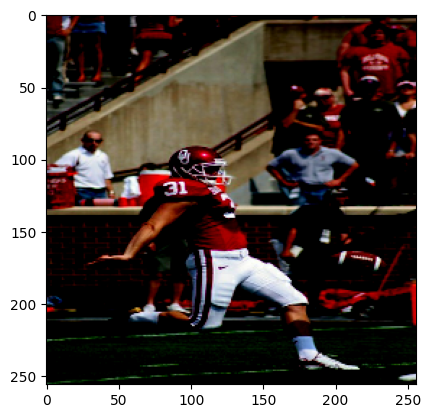

In [48]:
import matplotlib.pyplot as plt
plt.imshow(input_image[9000])

### PRETRAINED

In [63]:
##################################################
## import packages
##################################################

from transformers import GPT2TokenizerFast, ViTImageProcessor, VisionEncoderDecoderModel
from torch.utils.data import Dataset
import requests
import torch
import numpy as np
from PIL import Image
import pickle
# from torchvision import transforms
# from datasets import load_dataset
# import torch.nn as nn
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.47.1"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

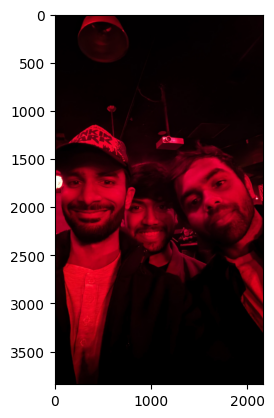

men with hats and makeup 


In [67]:
model_raw = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
image_processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer       = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

def show_n_generate(url, greedy = True, model = model_raw):
    image = Image.open(url)
    pixel_values   = image_processor(image, return_tensors ="pt").pixel_values
    plt.imshow(np.asarray(image))
    plt.show()

    if greedy:
        generated_ids  = model.generate(pixel_values, max_new_tokens = 30)
    else:
        generated_ids  = model.generate(
            pixel_values,
            do_sample=True,
            max_new_tokens = 30,
            top_k=5)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    print(generated_text)

url = "D:/Deep Learning Projects/Image captioning - flickr8k/test_images/dp_new.jpg"
# url = "https://raw.githubusercontent.com/michael-franke/npNLG/main/neural_pragmatic_nlg/pics/06-3DS-example.jpg"
# url = "https://img.welt.de/img/sport/mobile102025155/9292509877-ci102l-w1024/hrubesch-rummenigge-BM-Berlin-Gijon-jpg.jpg"
# url = "https://faroutmagazine.co.uk/static/uploads/2021/09/The-Cover-Uncovered-The-severity-of-Rage-Against-the-Machines-political-message.jpg"
# url = "https://media.npr.org/assets/img/2022/03/13/2ukraine-stamp_custom-30c6e3889c98487086d76869f8ba6a8bfd2fd5a1.jpg"

show_n_generate(url, greedy = False)